# Blankenbach Benchmark
## Steady isoviscous thermal convection

Steady convection with constant viscosity in a square box (l / h =1).
Temperature is fixed to zero on top and to $\Delta T$ at the bottom, no internal heat sources. Reflecting symmetry at the sidewalls, zero shear stress on all boundaries (freeslip).

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
boxHeight = 1000. * u.kilometer
boxLength = 1000. * u.kilometer

tempMin = 273.15 * u.degK
tempMax = 1273.15 * u.degK

refViscosity = 1e23 * u.pascal * u.second

KL = boxHeight
KT = (tempMax - tempMin)
Kt = 2000.*u.year
KM = refViscosity * KL * Kt

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[temperature]"]= KT
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"] = KM

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(1000. * u.kilometer, 1000. * u .kilometer),
                  gravity=(0., -10. * u.meter / u.second**2))

In [5]:
case1A = 1.0e23 * u.pascal * u.second
case1B = 1.0e22 * u.pascal * u.second
case1C = 1.0e21 * u.pascal * u.second

## Define Material property

In [6]:
Model.density = GEO.LinearDensity(4000. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.degK)
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.viscosity = case1A

The Raylegh number is defined as 

$$ Ra_0 = \frac{\alpha g \Delta T h^3}{\kappa \mu_0} $$

$\alpha$ is thermal expansion coefficient,
$\kappa$ is diffusivity,
$g$ is gravity,
$dT$ is the difference in temperature between top and bottom,
$h$ is the Model height,
$mu0$ is the kinematic viscosity.

In [7]:
alpha = Model.thermalExpansivity
kappa = Model.diffusivity
g = abs(Model.gravity[-1])
dT = KT
h = Model.height
mu0 = 1e23 * u.pascal * u.second / (4000 * u.kilogram / u.metre**3)

Ra0 = (alpha * g * dT * h**3) / (kappa * mu0)

print("Rayleigh Number:", Ra0.to_base_units())

Rayleigh Number: 10000.000000000004 dimensionless


## Define velocity boundary conditions

In [8]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], right=[0.,None], top=[None,0.], bottom=[None,0.])

## Define thermal boundary conditions

In [9]:
BoundaryBCs = Model.set_temperatureBCs(top=tempMin, bottom=tempMax)

## Define Initial Temperature perturbation

In [10]:
import math

boxLength = GEO.nd(boxLength)
boxHeight = GEO.nd(boxHeight)
tempMin = GEO.nd(tempMin)
tempMax = GEO.nd(tempMax)

Model.temperature.data[:] = 0.
pertStrength = GEO.nd(100. * u.kilometer)
deltaTemp = tempMax - tempMin

for index, coord in enumerate(Model.mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    Model.temperature.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    Model.temperature.data[index] = max(tempMin, min(tempMax, Model.temperature.data[index]))


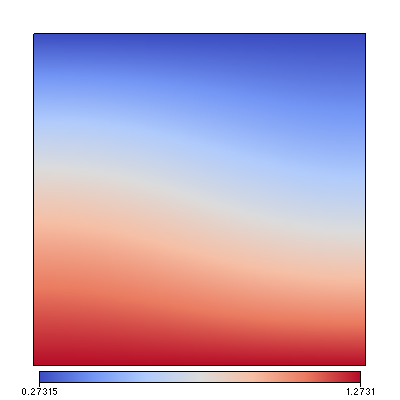

In [11]:
Fig = glucifer.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.show()

Analysis tools
-----

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [16]:
import underworld as uw
import underworld.function as fn

nuTop    = uw.utils.Integral( fn=Model.temperature.fn_gradient[1], 
                              mesh=Model.mesh, integrationType='Surface', 
                              surfaceIndexSet=Model.top_wall)

nuBottom = uw.utils.Integral( fn=Model.temperature,               
                              mesh=Model.mesh, integrationType='Surface', 
                              surfaceIndexSet=Model.bottom_wall)

In [17]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]

print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 0.785453


**RMS velocity**

The root mean squared velocity is defined by intergrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $V$ denotes the volume of the box.

In [19]:
intVdotV = uw.utils.Integral(fn.math.dot(Model.velocityField, Model.velocityField ), Model.mesh )
vrms = math.sqrt( intVdotV.evaluate()[0] )

print('Initial vrms = {0:.3f}'.format(vrms))

Initial vrms = 0.000


# PostSolve Hook

In [41]:
timeVal = []
vrmsVal = []
epsilon    = 1.e-8
velplotmax = 0.0
nuLast     = -1.0

def post_solve_function():

    # Define variables we want to retrieve as global
    global nuLast
    global timeVal
    global vrmsVal
    global velplotmax
    
    # Calculate & store the RMS velocity and Nusselt number.
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    nu   = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
    vrmsVal.append(vrms)
    timeVal.append(Model.time)
    velplotmax = max(vrms, velplotmax)
    
    # print output statistics 
    if(uw.rank()==0):
        print('v_rms = {0:.3f}; Nu = {1:.3f}; Rel change = {2:.3e}'
              .format(vrms, nu, abs((nu - nuLast)/nu)))
    nuLast = nu

In [42]:
Model.postSolveHook = post_solve_function

In [43]:
Model.init_model(temperature=False)

In [44]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [45]:
!rm -rf outputs/
Model.run_for(nstep=10)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:1 Model Time:  19341287.01221832 year dt: 3868257.402443664 year (2018-11-27 07:12:25)
v_rms = 0.000; Nu = 0.792; Rel change = 2.263e+00
Step:2 Model Time:  23209544.414661985 year dt: 3868257.402443664 year (2018-11-27 07:12:28)
v_rms = 0.000; Nu = 0.793; Rel change = 1.739e-03
Step:3 Model Time:  27077801.817105647 year dt: 3868257.402443664 year (2018-11-27 07:12:31)
v_rms = 0.000; Nu = 0.795; Rel change = 1.782e-03
Step:4 Model Time:  30946059.219549313 year dt: 3868257.402443664 year (2018-11-27 07:12:34)
v_rms = 0.000; Nu = 0.796; Rel change = 1.827e-03
Step:5 Model Time:  34814316.621992975 year dt: 3868257.402443664 year (2018-11-27 07:12:37)
v_rms = 0.000; Nu = 0.798; Rel change = 1.872e-03
Step:6 Model Time:  38682574.02443663 year dt: 3868257.402443664 year (2018-11-27 07:12:40)
v_rms = 0.000; Nu = 0.799; Rel change = 1.919e-03
Step:7 Model Time:  42550831.42688029 year dt: 3868257.402443664 year (2018-1

1


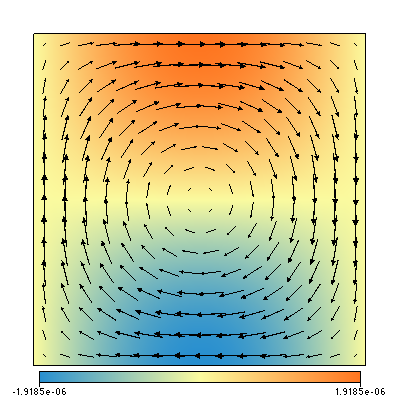

In [52]:
Fig = glucifer.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


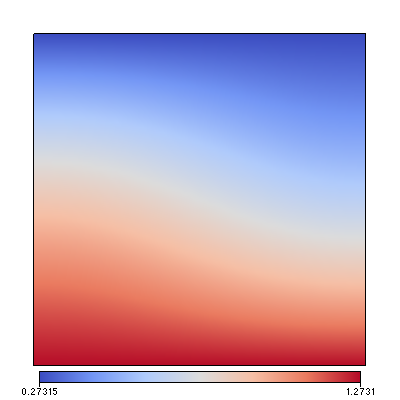

In [53]:
Fig = glucifer.Figure(figsize=(400,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.show()